In [7]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 9.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Load historical data using yfinance API
symbol_1 = "AAPL"
symbol_2 = "MSFT"
start_date = "2019-01-01"
end_date = "2022-01-01"

data_1 = yf.download(symbol_1, start=start_date, end=end_date)
data_2 = yf.download(symbol_2, start=start_date, end=end_date)

# Step 2: Calculate the spread between two stocks
spread = data_1['Close'] - data_2['Close']

# Step 3: Compute rolling z-score of the spread
zscore = (spread - np.mean(spread)) / np.std(spread)

# Step 4: Create a trading signal based on the z-score
signal = pd.Series(0, index=zscore.index)
signal[zscore > 1] = 1
signal[zscore < -1] = -1

# Step 5: Create a features dataset
features = pd.DataFrame({
    symbol_1: data_1['Close'],
    symbol_2: data_2['Close'],
    'zscore': zscore,
    'signal': signal.shift(1)
}).dropna()

# Step 6: Create a target variable
target = features['signal']

# Step 7: Split data into training and testing sets
split = int(len(features) * 0.8)
train_features = features.iloc[:split, :-1]
test_features = features.iloc[split:, :-1]
train_target = target.iloc[:split]
test_target = target.iloc[split:]

# Step 8: Fit a logistic regression model
model = LogisticRegression()
model.fit(train_features, train_target)

# Step 9: Evaluate the model
train_pred = model.predict(train_features)
test_pred = model.predict(test_features)
train_acc = accuracy_score(train_target, train_pred)
test_acc = accuracy_score(test_target, test_pred)
print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training accuracy: 0.9884105960264901
Testing accuracy: 0.13815789473684212


In [13]:
print("Numpy: %s ",np.__version__)
print("Pandas: %s ",pd.__version__)

Numpy: %s  1.22.4
Pandas: %s  1.4.4


In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Downloading historical data
symbol1 = yf.Ticker('MSFT')
symbol2 = yf.Ticker('GOOG')

df1 = symbol1.history(period='1y')
df2 = symbol2.history(period='1y')

# Creating features and labels
spread = df1['Close'] - df2['Close']
mean_spread = spread.mean()
std_spread = spread.std()
z_score = (spread - mean_spread) / std_spread

features = []
labels = []

for i in range(1, len(df1)):
    feature = [z_score[i - 1]]
    label = 0

    if spread[i] > mean_spread:
        label = 1

    features.append(feature)
    labels.append(label)

# Training the model
X = pd.DataFrame(features, columns=['feature_{}'.format(i) for i in range(len(features[0]))])
y = np.array(labels)

model = LogisticRegression()
model.fit(X, y)

# Making predictions
feature_today = [z_score[-1]]
X_today = pd.DataFrame([feature_today], columns=['feature_{}'.format(i) for i in range(len(feature_today))])

prediction = model.predict(X_today)[0]
probabilities = model.predict_proba(X_today)[0]

# Calculating P&L
symbol1_shares = 100
symbol2_shares = -prediction * (symbol1_shares * df1['Close'][-1]) / (df2['Close'][-1])
pnl = (symbol1_shares * (df1['Close'][-1] - df1['Close'][-2])) + (symbol2_shares * (df2['Close'][-1] - df2['Close'][-2]))
print('P&L: {}'.format(pnl))


P&L: -701.9887235679621


In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Download historical price data from Yahoo Finance
symbols = ['AAPL', 'AMZN', 'JPM', 'CVS']
price_data = yf.download(symbols, start='2019-01-01', end='2022-01-01')['Adj Close']

# Remove any assets with NaN values
price_data = price_data.dropna(axis=1)

# Compute returns and normalize price data
returns = price_data.pct_change().dropna()
price_data_norm = (price_data - price_data.mean()) / price_data.std()

# Fit PCA model
pca = PCA(n_components=2)
principal_components = pca.fit_transform(price_data_norm.T)
principal_df = pd.DataFrame(principal_components, index=price_data_norm.columns, columns=['PC1', 'PC2'])

# Fit k-means clustering model
kmeans = KMeans(n_clusters=2, random_state=420)
kmeans.fit(principal_df)
print(principal_df)
# Assign cluster labels to each asset
cluster_labels = kmeans.predict(principal_df)
print(len(cluster_labels))
# Create dataframe of assets and their assigned clusters
clustered_assets = pd.DataFrame({'asset': price_data_norm.columns, 'cluster': cluster_labels})

# Compute normalized price data for each asset in each cluster
clustered_data = {}
for cluster in set(cluster_labels):
    assets_in_cluster = clustered_assets[clustered_assets['cluster'] == cluster]['asset']
    clustered_data[cluster] = price_data_norm[assets_in_cluster]


[*********************100%***********************]  4 of 4 completed
            PC1       PC2
AAPL   6.685930  0.813500
AMZN  12.418074 -1.625657
CVS   -7.682766  6.426250
JPM  -11.421238 -5.614093


/Users/dhyeymavani/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [6]:
clustered_assets

NameError: name 'clustered_assets' is not defined

In [20]:
# Define correlation threshold for pairs trading
corr_threshold = 0.55

# Loop over clusters
for cluster in set(cluster_labels):
    # Get assets in current cluster
    assets_in_cluster = clustered_assets[clustered_assets['cluster'] == cluster]['asset']
    symbols = ['AAPL', 'AMZN', 'JPM', 'CVS']
    price_data = yf.download(symbols, start='2022-01-02', end='2023-03-31')['Adj Close']

    # Remove any assets with NaN values
    price_data = price_data.dropna(axis=1)

    # Compute returns and normalize price data
    returns = price_data.pct_change().dropna()
    # Compute pairwise correlation matrix for current cluster
    corr_matrix = returns[assets_in_cluster].corr()
    
    # Extract upper triangle of correlation matrix
    upper_tri = np.triu(corr_matrix, k=1)
    
    # Find pairs with correlation above threshold
    pairs = np.where(upper_tri > corr_threshold)
    pair_indices = [(i,j) for i,j in zip(pairs[0], pairs[1])]
    
    # Loop over pairs and trade them
    for pair in pair_indices:
        asset1 = assets_in_cluster[pair[0]]
        asset2 = assets_in_cluster[pair[1]]
        
        # Compute z-scored spread between assets
        spread = (returns[asset1] - returns[asset2]).rolling(window=20).apply(lambda x: (x[-1] - x.mean()) / x.std()).dropna()
        
        # Define trading rule based on spread
        if spread[-1] > 0.1:
            print(f"Buy {asset1} and sell {asset2}")
        elif spread[-1] < -0.1:
            print(f"Sell {asset1} and buy {asset2}")


NameError: name 'cluster_labels' is not defined

[*********************100%***********************]  4 of 4 completed


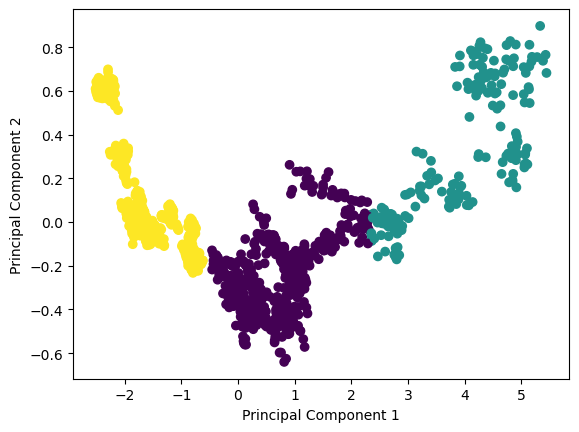

In [23]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set up API call to get historical price data
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
start_date = '2015-01-01'
end_date = '2020-12-31'
prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Standardize the data
prices_standardized = (prices - prices.mean()) / prices.std()

# Apply PCA to the data
pca = PCA(n_components=2)
prices_pca = pca.fit_transform(prices_standardized)

# Apply KMeans clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(prices_pca)

# Plot the results
plt.scatter(prices_pca[:, 0], prices_pca[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [31]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Set up API call to get historical price data
tickers = ['AAPL', 'MSFT']
start_date = '2015-01-01'
end_date = '2020-12-31'
prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate the spread between the two stocks
spread = prices['AAPL'] - prices['MSFT']

# Calculate the rolling mean and standard deviation of the spread
spread_mean = spread.rolling(window=50).mean()
spread_std = spread.rolling(window=50).std()

# Calculate the z-score of the spread
z_score = (spread - spread_mean) / spread_std

# Set up a trading signal
entry_threshold = 0.01
exit_threshold = 0.01
position = 0
positions = []

for i in range(len(z_score)):
    if z_score[i] > entry_threshold and position == 0:
        # Enter long position
        position = 1
    elif z_score[i] < -entry_threshold and position == 0:
        # Enter short position
        position = -1
    elif abs(z_score[i]) < exit_threshold and position != 0:
        # Exit position
        position = 0
    positions.append(position)

# Calculate the daily PnL of the portfolio
returns = np.log(prices / prices.shift(1))
positions = pd.Series(positions, index=returns.index)
pnl = returns[tickers[0]] * positions.shift(1) + returns[tickers[1]] * positions
pnl

[*********************100%***********************]  2 of 2 completed


Date
2015-01-02         NaN
2015-01-05   -0.000000
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.000000
                ...   
2020-12-23    0.020126
2020-12-24   -0.015479
2020-12-28   -0.045014
2020-12-29    0.017012
2020-12-30    0.019644
Length: 1510, dtype: float64

## Basic:

#### Long Only Pairs Trading - A simple pairs trading strategy focused on buying the loser! Signal is given by rolling correlation

This is an illustrative example of a Pairs Trading involving Coca-Cola (KO) and PepsiCo (PEP), despite being fundamentaly different companies, for example, KO has half the sales of PEP but has a higher Net Income however they both manufacture, distribute and sell soft beverages.

But the market already knows past information if any new information is released, specially if affects both companies like for example new regulations affecting the beverage market, its expected that it will affect both companies in the same way therefore the price of each should move in the same direction.

This strategy falls under the expectation that when prices depart from their historic equilibrium (quantified here as rolling correlation), the company that valued less in the last week will catchup during the trade session, being the positions open at open price (slippage & transaction costs can be factored in but aren't accounted for) and sold at close

In [5]:
# importing the necessary libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import yfinance          as yf

# initializing the graphics styling
plt.style.use('seaborn')

# Downloading data for assets under consideration
start_date, end_date = '2015-01-01', '2020-12-31'
PEP = yf.download("PEP", start=start_date, end=end_date)
KO = yf.download("KO", start=start_date, end=end_date)

/var/folders/rb/x4vhwjb16wj764ztdb96gnlh0000gn/T/ipykernel_22001/1539247628.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
# initializing the transaction costs that we are assuming
tc = -0.0005

pairs = pd.DataFrame({'TPEP':PEP['Close'].shift(1)/PEP['Close'].shift(2)-1,
                      'TKO':KO['Close'].shift(1)/KO['Close'].shift(2)-1})

# Criteria to select which asset we're gonna buy, in this case, the one that had the lowest return yesterday
pairs['Target'] = pairs.min(axis=1)

# Signal that triggers the purchase of the asset
pairs['Correlation'] = ((PEP['Close'].shift(1)/PEP['Close'].shift(20)-1).rolling(window=9)
                        .corr((KO['Close'].shift(1)/KO['Close'].shift(20)-1)))

Signal = pairs['Correlation'] < 0.9

# We're holding positions that weren't profitable yesterday
HoldingYesterdayPosition = ((pairs['Target'].shift(1).isin(pairs['TPEP']) &
                             (PEP['Close'].shift(1)/PEP['Open'].shift(1)-1 < 0)) |
                            (pairs['Target'].shift(1).isin(pairs['TKO']) &
                             (KO['Close'].shift(1)/KO['Open'].shift(1)-1 < 0))) # if tc, add here

# Since we aren't using leverage, we can't enter on a new position if
# we entered on a position yesterday (and if it wasn't profitable)
NoMoney = Signal.shift(1) & HoldingYesterdayPosition

pairs['PEP'] = np.where(NoMoney,
                        np.nan,
                        np.where(PEP['Close']/PEP['Open']-1 < 0,
                                 PEP['Close'].shift(-1)/PEP['Open']-1,
                                 PEP['Close']/PEP['Open']-1))

pairs['KO'] = np.where(NoMoney,
                       np.nan,
                       np.where(KO['Close']/KO['Open']-1 < 0,
                                KO['Close'].shift(-1)/KO['Open']-1,
                                KO['Close']/KO['Open']-1))

pairs['Returns'] = np.where(Signal,
                            np.where(pairs['Target'].isin(pairs['TPEP']),
                                      pairs['PEP'],
                                      pairs['KO']),
                             np.nan) # if tc, add here

pairs['CumulativeReturn'] = pairs['Returns'].dropna().cumsum()

In [7]:
# Pepsi returns
ReturnPEP = PEP['Close']/PEP['Open']-1
BuyHoldPEP = PEP['Adj Close']/float(PEP['Adj Close'][:1])-1

# Coca Cola returns
ReturnKO = KO['Close']/KO['Open']-1
BuyHoldKO = KO['Adj Close']/float(KO['Adj Close'][:1])-1

# Benchmark
ReturnBoth = (ReturnPEP+ReturnKO)/2
BuyHoldBoth = ((BuyHoldPEP+BuyHoldKO)/2).fillna(method='ffill')

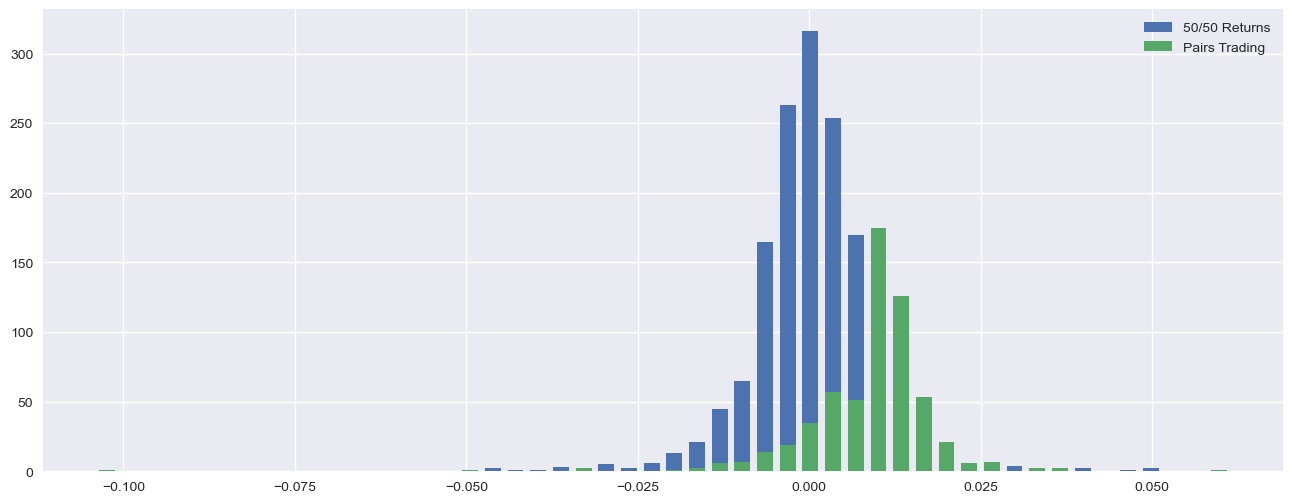

=====Strategy Returns=====
Mean return = 0.02 %
Standard deviaton = 1.23 %
Worst return = -14.41 %
Best return = 6.7 %
Lower quantile = -0.45 %
Median return = 0.21 %
Upper quantile = 0.6 %


In [8]:
returns = pairs['Returns'].dropna()
cumulret = pairs['CumulativeReturn'].dropna()

fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(ReturnBoth.dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2

ax.bar(center, hist1, align='center', width=width, label='50/50 Returns')

hist2, bins2 = np.histogram(returns, bins=50)
ax.bar(center, hist2, align='center', width=width, label='Pairs Trading')

plt.legend()
plt.show()

print('=====Strategy Returns=====')
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton =',round((returns.std())*100,2),"%")
print("==========================")
print('Worst return =',round((min(returns))*100,2),"%")
print('Best return =',round((max(returns))*100,2),"%")
print("=========================")
print('Lower quantile =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile =',round((returns.quantile(q=0.75))*100,2),"%")

In [9]:
# Some stats, this could be improved by trying to estimate a yearly sharpe, among many others
executionrate = len(returns)/len(ReturnBoth)

maxdd = round(max(np.maximum.accumulate(cumulret)-cumulret)*100,2)

mask = returns<0
diffs = np.diff(mask.astype(int))
start_mask = np.append(True,diffs==1) 
mask1 = mask & ~(start_mask & np.append(diffs==-1,True))
id = (start_mask & mask1).cumsum()
out = np.bincount(id[mask1]-1,returns[mask1])
badd = round(max(-out)*100,2)

spositive = returns[returns > 0]
snegative = -returns[returns < 0]
winrate = round((len(spositive)/(len(spositive)+len(snegative)))*100,2)

beta = round(returns.corr(ReturnBoth),2)

sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)

tret = round((float(cumulret[-1:]))*100,2)

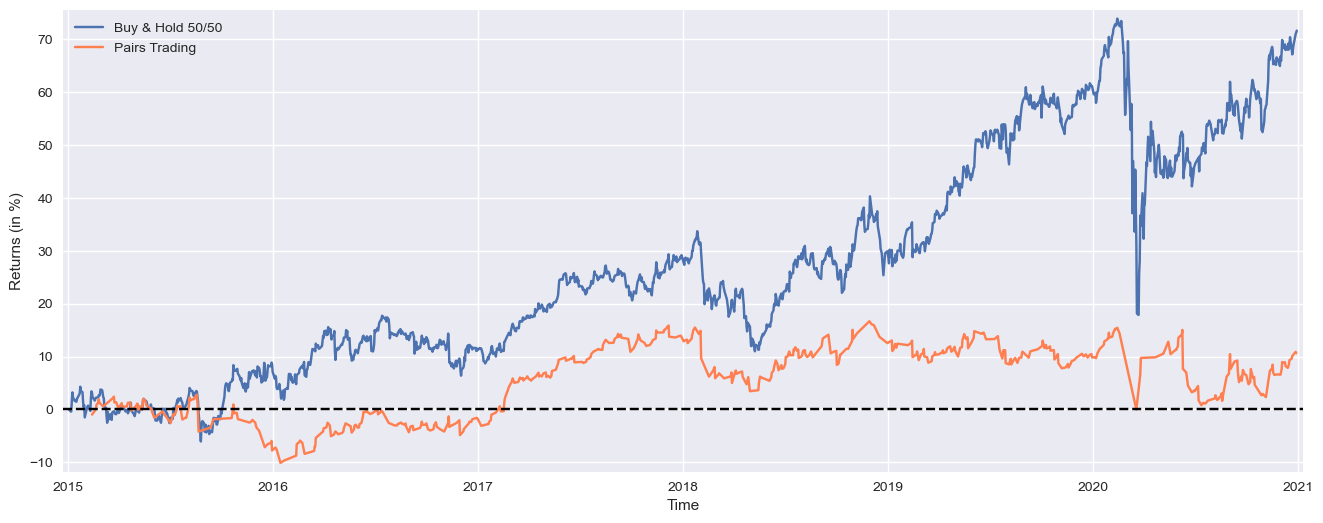

Cumulative Return =  10.64 %
Execution Rate =  39.01 %
Win Rate =  65.58 %
Maximum Loss =  16.71 %
Maximum Consecutive Loss =  15.49 %
Beta =  0.7
Sharpe =  1.68


In [10]:
plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Buy & Hold 50/50')
plt.plot(cumulret*100, label='Pairs Trading', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print("Cumulative Return = ",tret,"%")
print("=========================")
print("Execution Rate = ",round(executionrate*100,2),"%")
print("Win Rate = ",winrate,"%")
print("=========================")
print("Maximum Loss = ",maxdd,"%")
print("Maximum Consecutive Loss = ",badd,"%")
print("=========================")
print("Beta = ",beta)
print("Sharpe = ",sharpe)
# Return ("alpha") decay is pretty noticeable from 2011 onwards, most likely due to overfitting, they're not reinvested

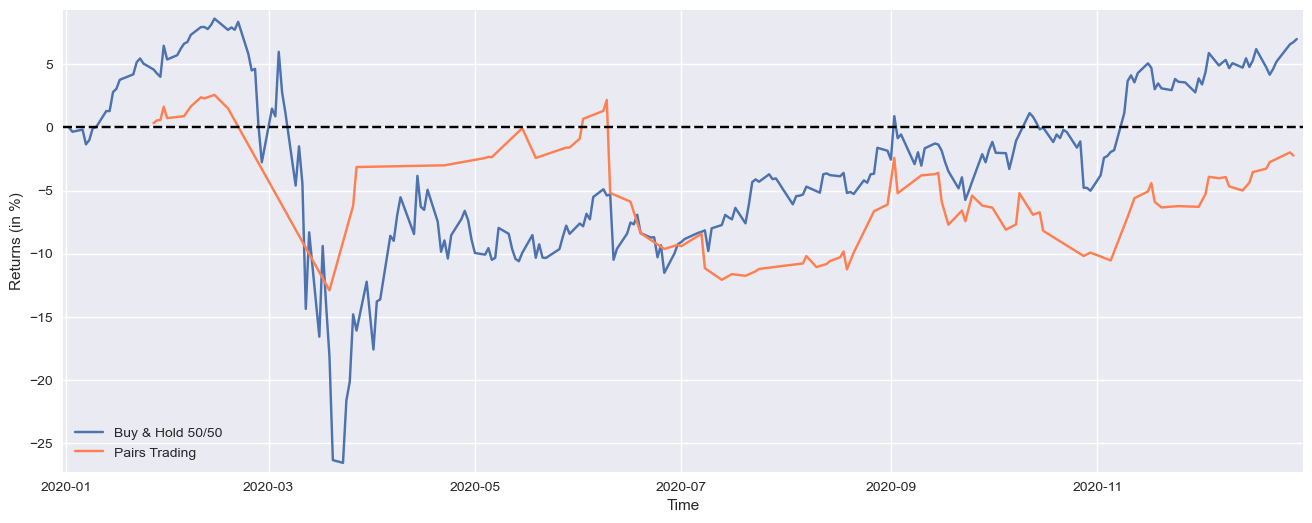

Buy & Hold 50/50 YTD Performance (at 1 July 2020) = 7.0 %
Strategy YTD Performance = -2.2 %


In [11]:
BuyHoldBothYTD = (((PEP['Adj Close'][-252:]/float(PEP['Adj Close'][-252])-1)+(KO['Adj Close'][-252:]/float(KO['Adj Close'][-252])-1))/2).fillna(method='ffill')
StrategyYTD = returns[-92:].cumsum()

plt.figure(figsize=(16,6))
plt.plot(BuyHoldBothYTD*100, label='Buy & Hold 50/50')
plt.plot(StrategyYTD*100, label='Pairs Trading', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print('Buy & Hold 50/50 YTD Performance (at 1 July 2020) =',round(float(BuyHoldBothYTD[-1:]*100),1),'%')
print('Strategy YTD Performance =',round(float(StrategyYTD[-1:]*100),1),'%')

## Moderate:

### ML Based Pairs Trading - A simple Machine Learning example, Decision Tree Regressors applied to the previous pair (also requires Scikit-Learn)


In [12]:
# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Tree models and data pre-processing
from numpy               import vstack, hstack
from sklearn             import tree

# Fancy graphics
plt.style.use('seaborn')

# Assets under consideration
tickers = ['PEP']

start_date = '2015-01-01'
end_date = '2020-12-31'
prices = yf.download(tickers, start=start_date, end=end_date)


PEP = prices.drop('Volume',axis=1)

tickers = ['KO']

start_date = '2015-01-01'
end_date = '2020-12-31'
prices = yf.download(tickers, start=start_date, end=end_date)


KO = prices.drop('Volume',axis=1)

# A (lagged) technical indicator (Average True Range)
def ATR(df, n):
    df = df.reset_index()
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = (max(df.loc[i+1, 'High'], df.loc[i, 'Close']) -
              min(df.loc[i+1, 'Low'], df.loc[i, 'Close']))
        TR_l.append(TR)
        i = i + 1
    return pd.Series(TR_l).ewm(span=n, min_periods=n).mean()

/var/folders/rb/x4vhwjb16wj764ztdb96gnlh0000gn/T/ipykernel_22001/2265064018.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
variables = pd.DataFrame({'TPEP':(PEP['Close']/PEP['Close'].shift(7)-1).shift(1),
                      'TKO':(KO['Close']/KO['Close'].shift(6)-1).shift(1)})

variables['Target'] = variables.min(axis=1)
variables['IsPEP']  = variables['Target'].isin(variables['TPEP'])

variables['Open']   = np.where(variables['Target'].isin(variables['TPEP']),
                               PEP['Open'],
                               KO['Open'])

variables['Close']  = np.where(variables['Target'].isin(variables['TPEP']),
                               PEP['Close'],
                               KO['Close'])

variables['Returns'] = variables['Close']/variables['Open']-1

variables['APEP'] = PEP['Open']
variables['AKO']  = KO['Open']

variables = variables.reset_index().drop('Date',axis=1)

variables['ATR'] = ATR(PEP,40)

variables = variables.dropna()
variables = variables.reset_index().drop('index',axis=1)

# This is a minimalistic example, adding more information (which is no easy task)
# will much likely yield a better signal to noise ratio

features  = ['IsPEP','AKO','ATR','APEP']

In [14]:
training = 38
testing = 3
seed = 123

returns = []

# Rolling calibration and testing of the Decision Tree Regressors
for ii in range(0, len(variables)-(training+testing), testing):
    X, y = [], []

    iam  = ii+training
    lazy = ii+training+testing

    # Training the model with the last 38 days
    for i in range(ii, iam):
        X.append([variables.iloc[i][var] for var in features])
        y.append(variables.iloc[i].Close)

    model = tree.DecisionTreeRegressor(max_depth=19,
                                       min_samples_leaf=3,
                                       min_samples_split=16,
                                       random_state=seed)
    model.fit(vstack(X), hstack(y))

    XX = []

    # Testing it out-of-sample, its used for the next 3 days
    for i in range(iam, lazy):
        XX.append([variables.iloc[i][var] for var in features])

    # We trade if the predicted close price is superior to the open price
    trades = np.where(model.predict(vstack(XX)) > variables['Open'][iam:lazy],
                      variables['Returns'][iam:lazy],
                      np.nan)

    for values in trades:
        returns.append(values)

In [15]:
CompRes = pd.DataFrame({'Baseline': variables[-len(returns):].set_index(PEP[-len(returns):].index)['Returns'],
                        'DTR': returns})

CompRes['Baseline'].describe()

count    1431.000000
mean        0.000346
std         0.010219
min        -0.087008
25%        -0.004235
50%         0.000639
75%         0.005259
max         0.094430
Name: Baseline, dtype: float64

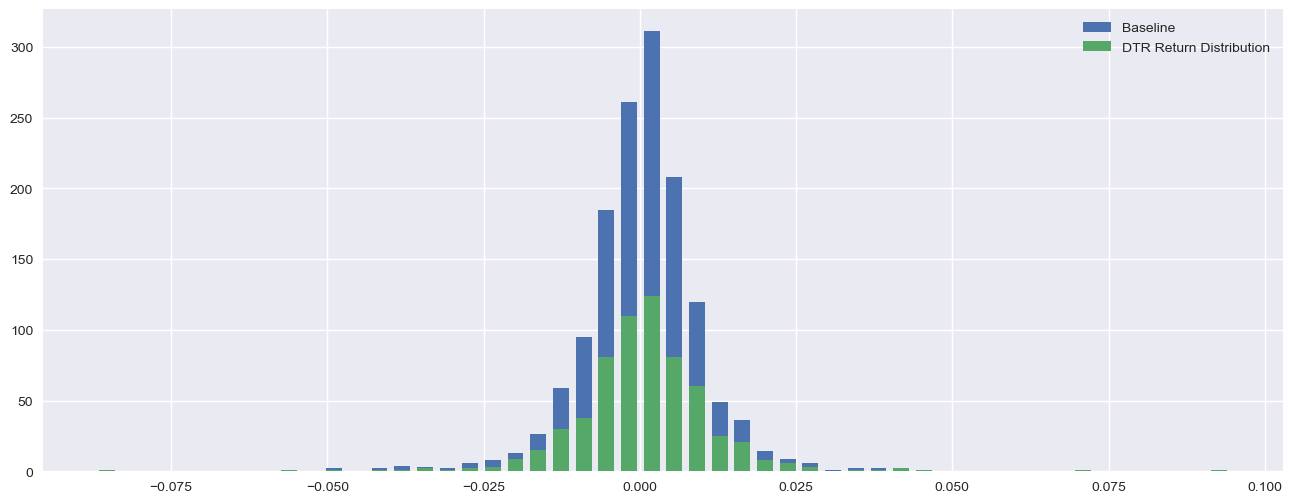

count    631.000000
mean       0.000596
std        0.011888
min       -0.087008
25%       -0.004750
50%        0.000720
75%        0.006062
max        0.094430
Name: DTR, dtype: float64

In [16]:
fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(CompRes['Baseline'].dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2

ax.bar(center, hist1, align='center', width=width, label='Baseline')

hist2, bins2 = np.histogram(CompRes['DTR'].dropna(), bins=50)
ax.bar(center, hist2, align='center', width=width, label='DTR Return Distribution')

plt.legend()
plt.show()

CompRes['DTR'].describe()

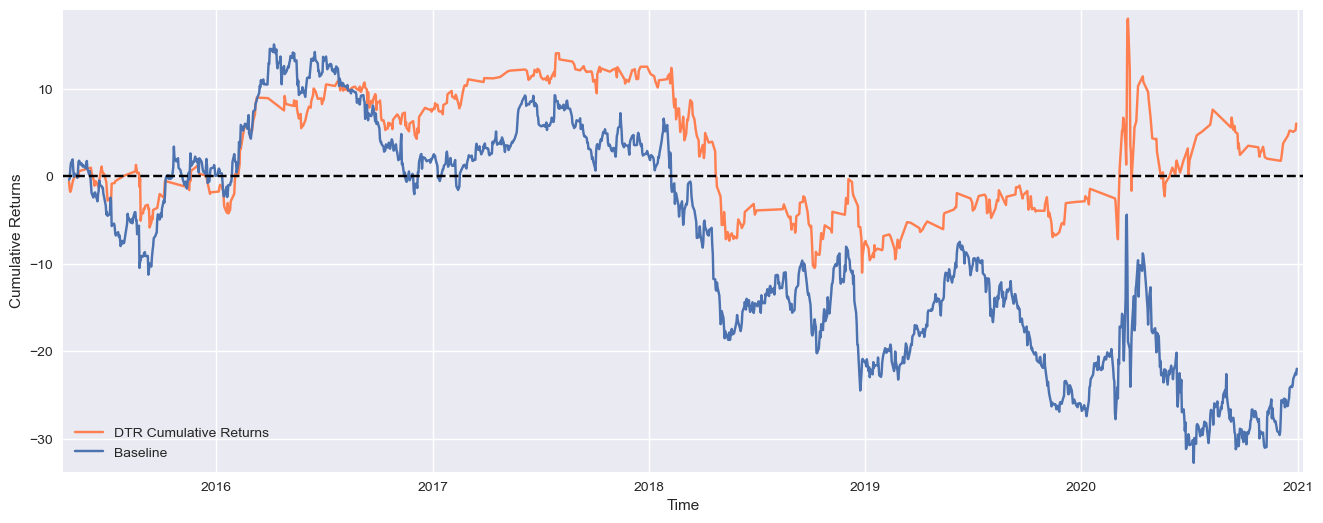

In [17]:
tc = -0.0005 #Simulating 0.05% transaction costs

plt.figure(figsize=(16,6))
plt.plot(((CompRes['DTR'].dropna()+tc).cumsum())*100, color='coral', label='DTR Cumulative Returns')
plt.plot(((CompRes['Baseline']+tc).cumsum())*100, label='Baseline')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

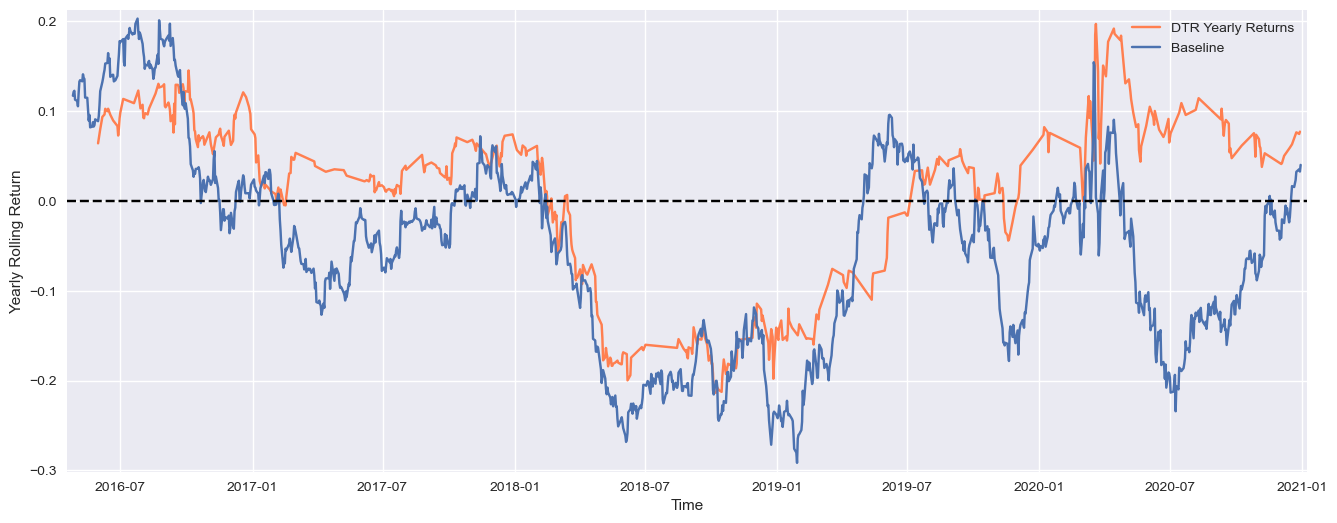

count    513.000000
mean       0.002501
std        0.098860
min       -0.213579
25%       -0.070598
50%        0.030996
75%        0.073512
max        0.196870
Name: DTR, dtype: float64

In [18]:
plt.figure(figsize=(16,6))
plt.plot((CompRes['DTR'].dropna()+tc).rolling(window=119).sum(), color='coral', label='DTR Yearly Returns')
plt.plot((CompRes['Baseline']+tc).rolling(window=252).sum(), label='Baseline')
plt.xlabel('Time')
plt.ylabel('Yearly Rolling Return')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
# Descriptive statistics of the strategy rolling yearly return
#(assuming 119 trades per year)
((CompRes['DTR'].dropna()+tc).rolling(window=119).sum()).describe()